korzystamy z bazy danych CelebFaces Attributes (CelebA)
chcemy wykrywac uśmiechy na twarzy na podstawie zdjęcia, 

Pozwoli to na weryfikację, czy ludziom w kinie podoba się komedia, którą oglądają. 
Pozwoli to na wstępną ocenę jak populany może być film i na tej podstawie chociażby ustalania intensywności i harmonogramów filmów wyświetlanych w kinie.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
! pip install -q kaggle 

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir /root/.kaggle
! mv kaggle.json /root/.kaggle

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:40<00:00, 43.4MB/s]
100% 1.33G/1.33G [00:40<00:00, 35.4MB/s]


In [ ]:
! unzip celeba-dataset.zip -d celeba-dataset

Streaming output truncated to the last 5000 lines.
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba-dataset/img_align_celeba/img_

In [ ]:
# attributes_df = pd.read_csv("/content/list_attr_celeba.csv")
# bboxes_df = pd.read_csv("/content/list_bbox_celeba.csv")
# landmarks_df = pd.read_csv("/content/list_landmarks_align_celeba.csv")
# eval_df = pd.read_csv("/content/list_eval_partition.csv")

In [ ]:
attributes_df = pd.read_csv("/content/celeba-dataset/list_attr_celeba.csv")
bboxes_df = pd.read_csv("/content/celeba-dataset/list_bbox_celeba.csv")
landmarks_df = pd.read_csv("/content/celeba-dataset/list_landmarks_align_celeba.csv")
eval_df = pd.read_csv("/content/celeba-dataset/list_eval_partition.csv")

In [ ]:
attributes_df.head(10)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [ ]:
#WYKRESY ROZKŁADU danych kolumnowych (histogram/wykres słupkowy)
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 45]] #Do celów wyświetlania wybór kolumn o wartościach od 1 do 45
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

Rozłożenie wartości poddawanych przez nas analizie są równe (cecha występująca i niewystępująca)

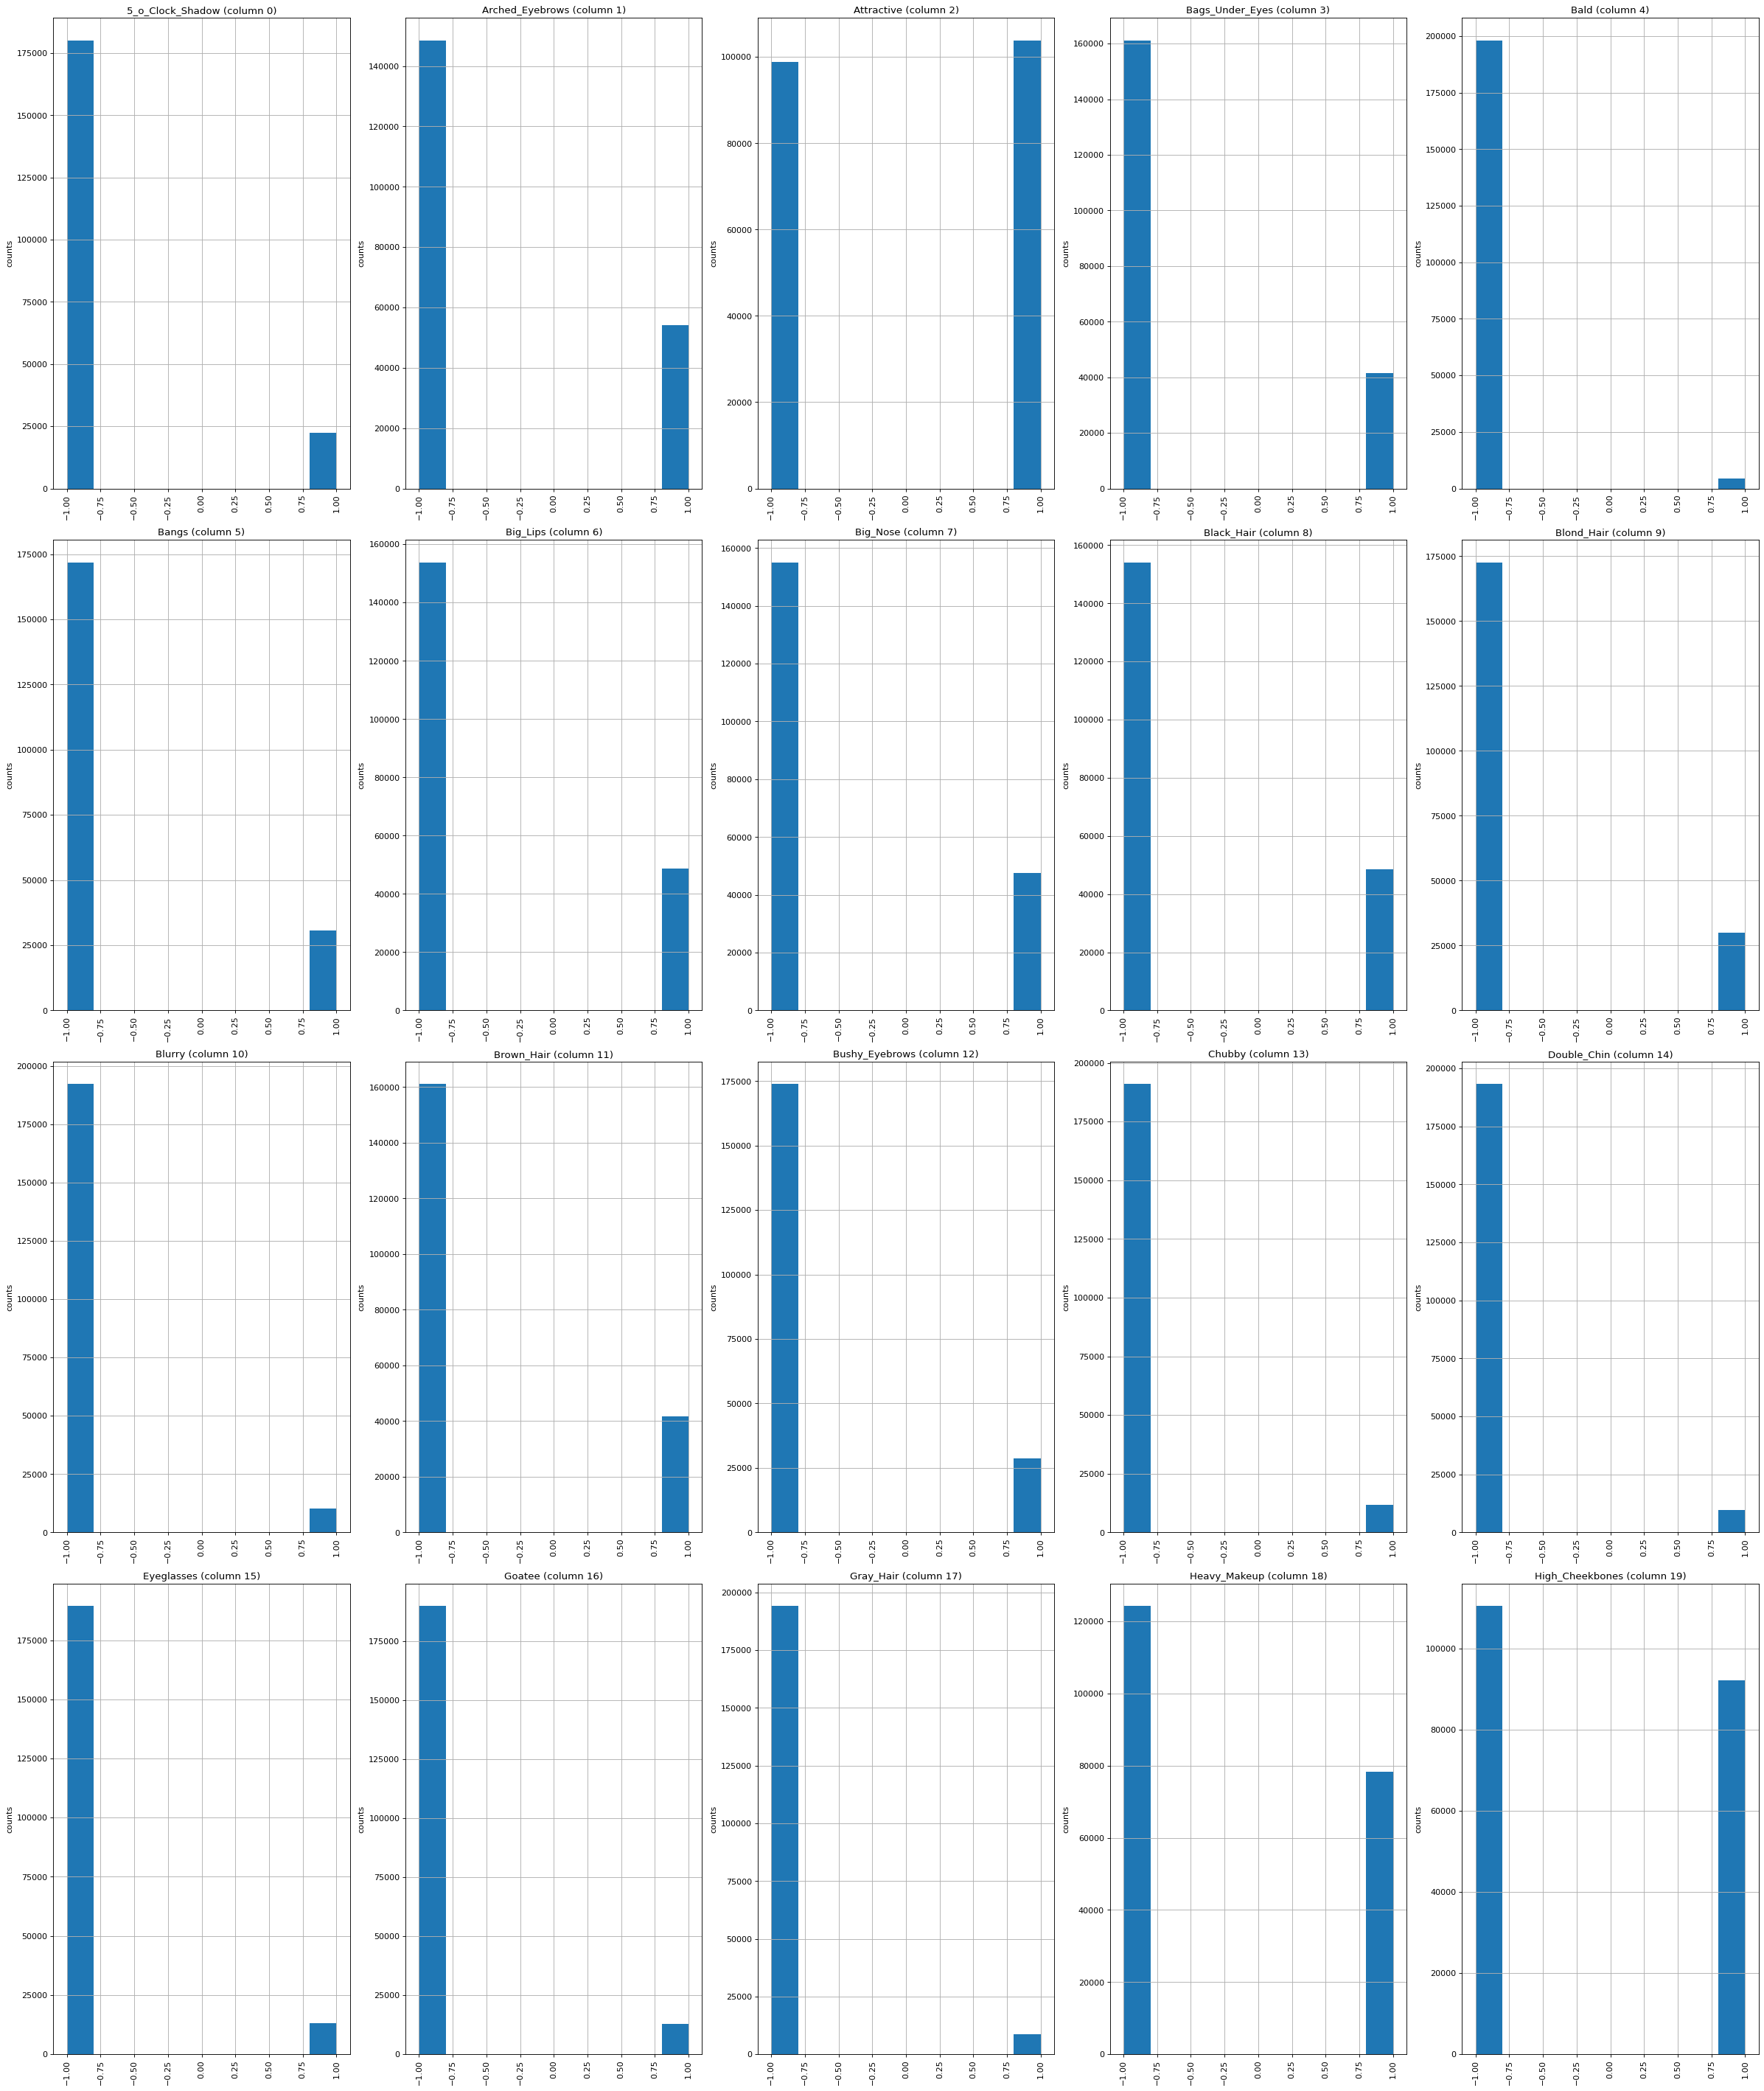

In [ ]:
plotPerColumnDistribution(attributes_df, 20, 5)

In [ ]:
nRowsRead = 1000 #'brak' w przypadku, kiedy chcesz wyświetlić cały plik 
# list_attr_celeba posiada 202 599 wierszy, ale my przeglądamy pierwsze 1000
attributes_df_pic = pd.read_csv("/content/celeba-dataset/list_attr_celeba.csv", delimiter=',', nrows = nRowsRead)
attributes_df_pic.dataframeName = "list_attr_celeba.csv"
nRow, nCol = attributes_df_pic.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 41 columns


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # wyrzucanie kolumn z NaN
    df = df[[col for col in df if df[col].nunique() > 1]] #zostawiamy kolumny, gdzie jest przynajmniej 1 unique value
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

Najwyższą korelacją z uśmiechem charakteryzują się High_CHeekbones oraz Mouth_Slighty_Open 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


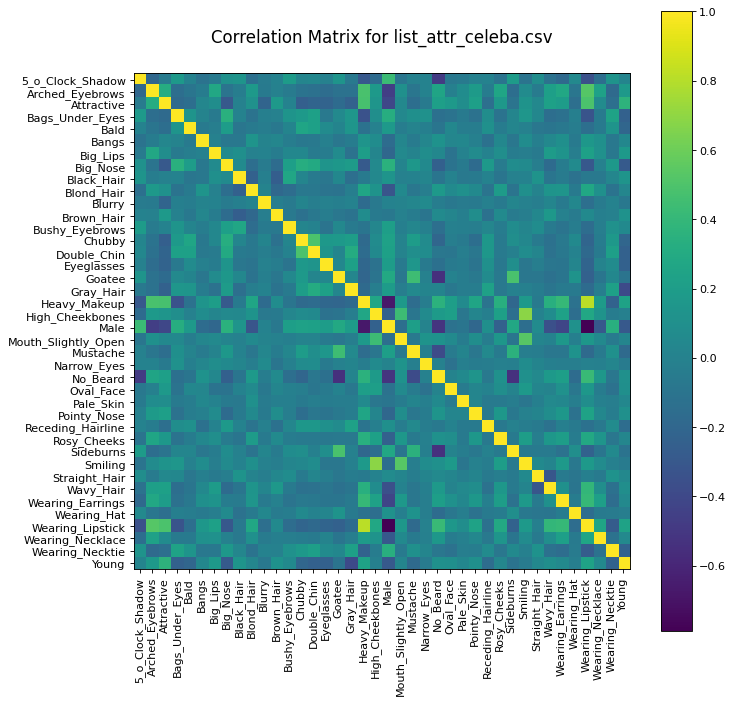

In [ ]:
plotCorrelationMatrix(attributes_df_pic, 10)

In [ ]:
eval_df.head(10)

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
5,000006.jpg,0
6,000007.jpg,0
7,000008.jpg,0
8,000009.jpg,0
9,000010.jpg,0


In [ ]:
eval_df.partition.value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

0 - obrazki treningowe
1 - testowe
2 - walidacyjne

In [ ]:
train_df = eval_df[eval_df['partition'] == 0]
test_df = eval_df[eval_df['partition'] == 1]
val_df = eval_df[eval_df['partition'] == 2]

iteracje dla obrazków

In [ ]:
train_array = []

In [ ]:
"/content/archive.zip"

'/content/archive.zip'

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

**KOLEJNE KROKI**
- wczytac image za pomocą funkcji cv2.imread (tylko trzeba podać poprawną ścieżkę + nazwę ID) --> os.path.join('ścieżka do folderu', image)
- resize, zmniejszyć żeby szybciej działało, np. do rozm. 150x150, za pomocą cv2.resize
- normalizowanie, czyli dzielenie przez 255, 
- wrzucić obrazek do listy train array --> zappendować obrazek do train_array
- w pętli obrazki będą wrzucane do array

- potrzebujemy jeszcze ID, na podstawie ID obrazku, trzeba wyszukać w tej innej tabeli wyszukac flagę smiling i dodać ten 'y' do 'y train_array', tylko wcześniej trzeba zainicjowac y_train_array.

In [ ]:
X_train_array = []
y_train = []
for image_id in list(train_df.image_id)[:1000]:
  #wczytać img za pomocą funkcji cv2.imread(poprawna ścieżka +nr id)os.path.join('ścieżka do folderu', image)
  image = cv2.imread(os.path.join("/content/celeba-dataset/img_align_celeba/img_align_celeba", image_id))
  #zmniejszyć 150x150 - cv2.resize
  #resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
  image = cv2.resize(image, (150,150))
  #znormalizować /255
  image = image/255
  #wrzucić do train_array
  X_train_array.append(image)
  #wyszukać y (uśmiech) wrzucic do y_train_array
  y = attributes_df[attributes_df['image_id'] == image_id].Smiling.values[0]
  if y == -1:
    y_train.append(0)
  else:
    y_train.append(1)

stworzyć 
test_array
val_array
wyświetlić shape dla wszystkich array

In [ ]:
X_test_array = []
y_test = []
for image_id in list(test_df.image_id)[:1000]:
  #wczytać img za pomocą funkcji cv2.imread(poprawna ścieżka +nr id)os.path.join('ścieżka do folderu', image)
  image = cv2.imread(os.path.join("/content/celeba-dataset/img_align_celeba/img_align_celeba", image_id))
  #zmniejszyć 150x150 - cv2.resize
  image = cv2.resize(image, (150,150))
  # #znormalizować /255
  image = image/255
  #wrzucić do train_array
  X_test_array.append(image)
  #wyszukać y (uśmiech) wrzucic do y_train_array
y = attributes_df[attributes_df['image_id'] == image_id].Smiling.values[0]
if y == -1:
    y_test.append(0)
else:
    y_test.append(1)

In [ ]:
X_val_array = []
y_val = []
for image_id in list(val_df.image_id)[:1000]:
  #wczytać img za pomocą funkcji cv2.imread(poprawna ścieżka +nr id)os.path.join('ścieżka do folderu', image)
  image = cv2.imread(os.path.join("/content/celeba-dataset/img_align_celeba/img_align_celeba", image_id))
  #zmniejszyć 150x150 - cv2.resize
  image = cv2.resize(image, (150,150))
  # #znormalizować /255
  image = image/255
  #wrzucić do train_array
  X_val_array.append(image)
  #wyszukać y (uśmiech) wrzucic do y_train_array
y = attributes_df[attributes_df['image_id'] == image_id].Smiling.values[0]
if y == -1:
    y_val.append(0)
else:
    y_val.append(1)

In [ ]:
type(y_train)

list

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.utils import to_categorical
X_train_array = np.array(X_train_array)
y_train = np.array(y_train)
X_test_array = np.array(X_test_array)
y_test = np.array(y_test)
X_val_array = np.array(X_val_array)
y_val = np.array(y_val)

In [ ]:
y_train

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical (y_train)
y_test_one_hot = to_categorical (y_test)
y_val_one_hot = to_categorical (y_val)

In [ ]:
y_train_one_hot

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
#tworzenie modelu i ustalanie jego parametrów
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", kernel_initializer = "he_uniform", padding = "same", 
                 input_shape = (150, 150, 3)))
model.add(Conv2D(64, (3, 3), activation = "relu", kernel_initializer = "he_uniform", padding = "same"))
model.add(BatchNormalization())
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.02))
model.add(BatchNormalization())
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.01))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(2, activation = "softmax"))

In [ ]:
#kompilowanie modelu
model.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
#fittowanie modelu
model.fit(x = X_train_array, y = y_train_one_hot, batch_size = 64, epochs = 5, verbose = 2, validation_data = (X_test_array, y_test_one_hot))

Epoch 1/5


ValueError: ignored

In [ ]:
X_train_array.shape

In [ ]:
y_train_one_hot